# Feature Reduction

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from typing import Type
from matplotlib.colors import BoundaryNorm
from sklearn.base import TransformerMixin
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA, TruncatedSVD, NMF, FastICA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import Isomap, LocallyLinearEmbedding
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.pipeline import Pipeline
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection

In [2]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
%matplotlib inline

In [3]:
warnings.filterwarnings("ignore")

In [4]:
X, y = load_digits(return_X_y=True)
X_train, _, y_train, _ = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=42, stratify=y)

In [5]:
def plot_feature_reduction(transformer_cls: Type[TransformerMixin], X: np.ndarray, y: np.ndarray) -> None:
    x_1d = transformer_cls(n_components=1).fit_transform(X, y)
    x_2d = transformer_cls(n_components=2).fit_transform(X, y)
    x_3d = transformer_cls(n_components=3).fit_transform(X, y)

    n_classes = np.unique(y).shape[0]
    cmap = plt.get_cmap("tab10", n_classes)
    norm = BoundaryNorm(np.arange(-0.5, n_classes, 1), cmap.N)

    fig = plt.figure(figsize=(20, 5))

    ax1 = fig.add_subplot(1, 3, 1)
    ax1.scatter(x=x_1d[:, 0], y=np.zeros_like(x_1d[:, 0]), c=y, cmap=cmap, norm=norm)
    ax1.set_title(f"{transformer_cls.__name__}(n_components=1)")

    ax2 = fig.add_subplot(1, 3, 2)
    ax2.scatter(x=x_2d[:, 0], y=x_2d[:, 1], c=y, cmap=cmap, norm=norm)
    ax2.set_title(f"{transformer_cls.__name__}(n_components=2)")

    ax3 = fig.add_subplot(1, 3, 3, projection="3d")
    sc = ax3.scatter(xs=x_3d[:, 0], ys=x_3d[:, 1], zs=x_3d[:, 2], c=y, cmap=cmap, norm=norm)
    ax3.set_title(f"{transformer_cls.__name__}(n_components=3)")

    fig.colorbar(sc, ax=[ax1, ax2, ax3], ticks=np.arange(n_classes))

### Feature Reduction Techniques

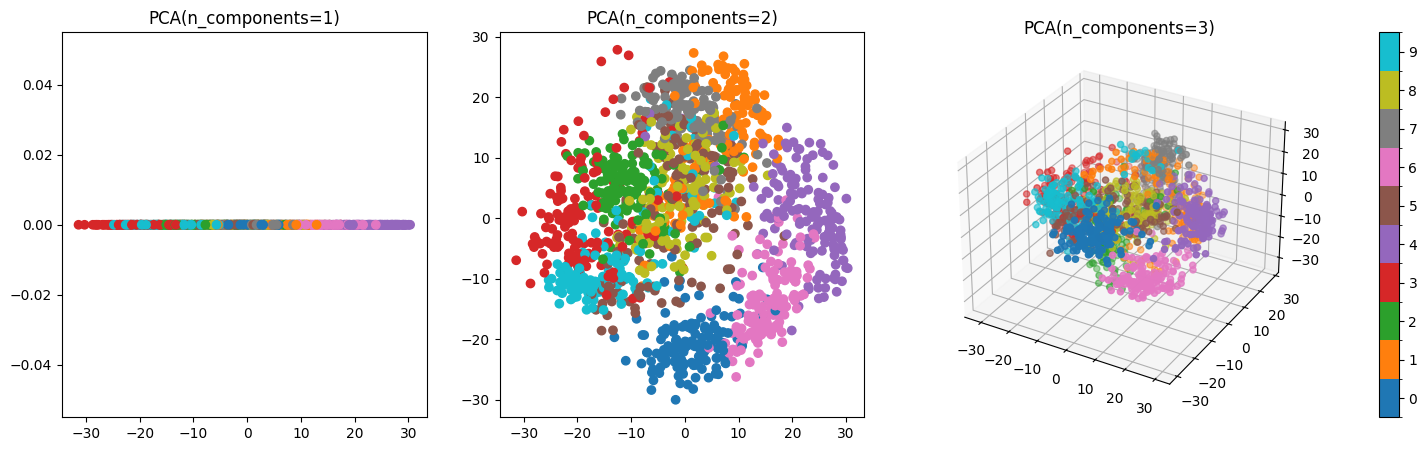

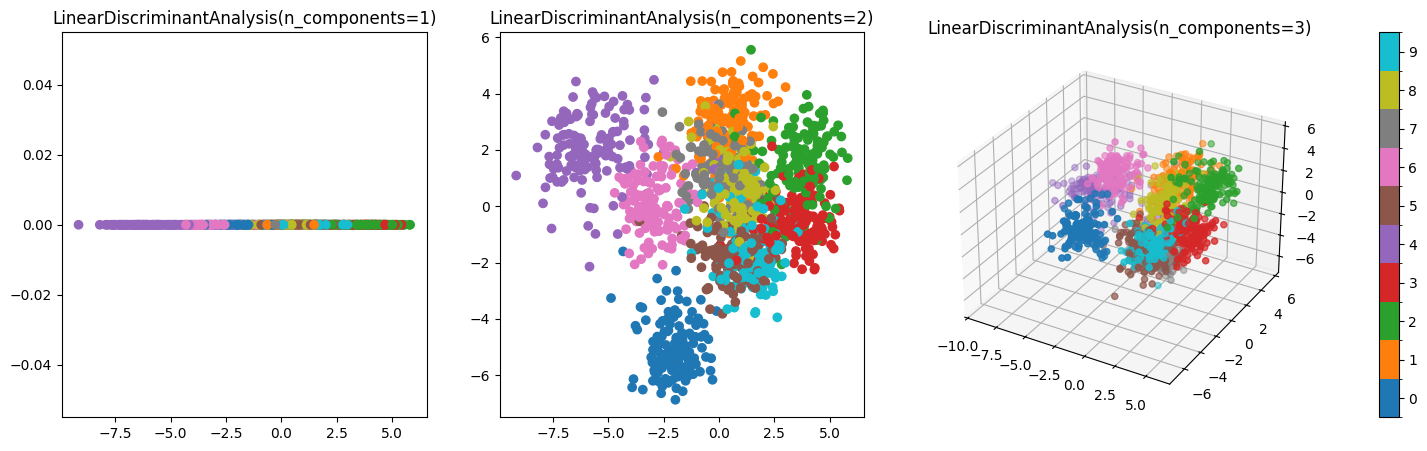

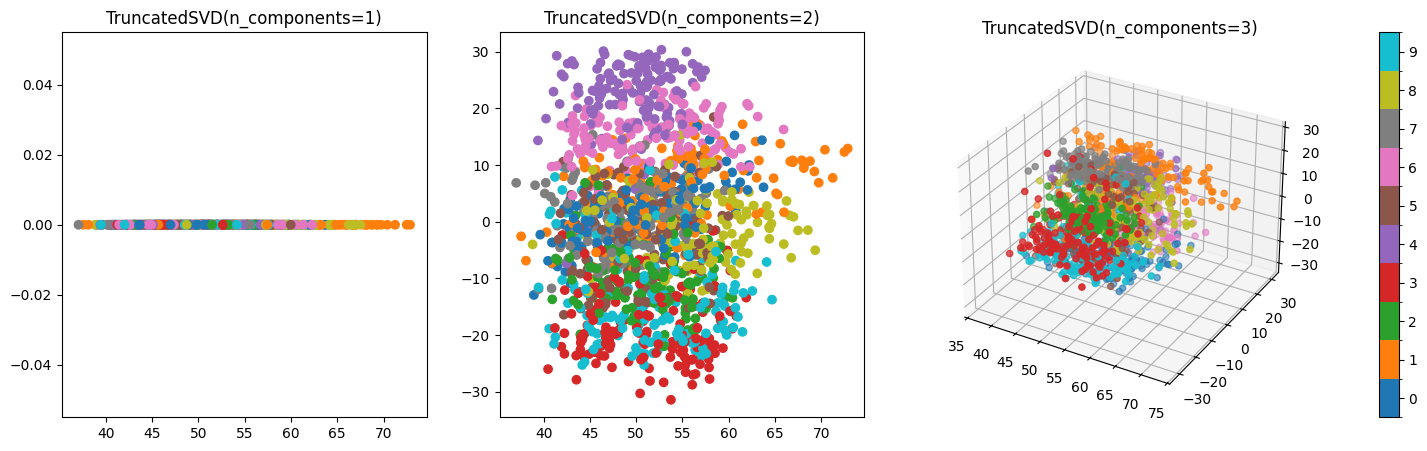

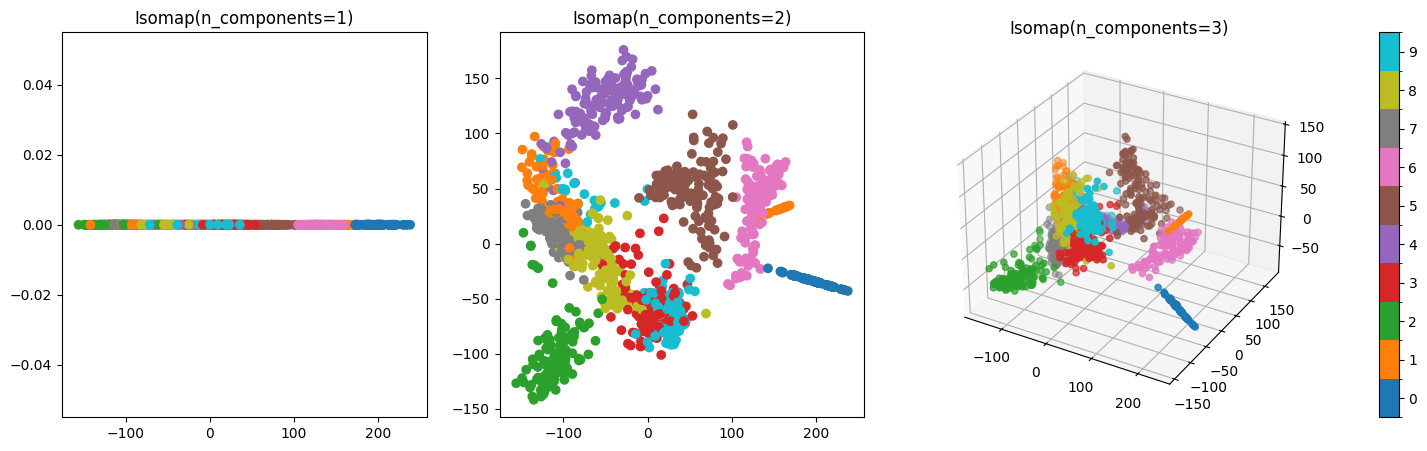

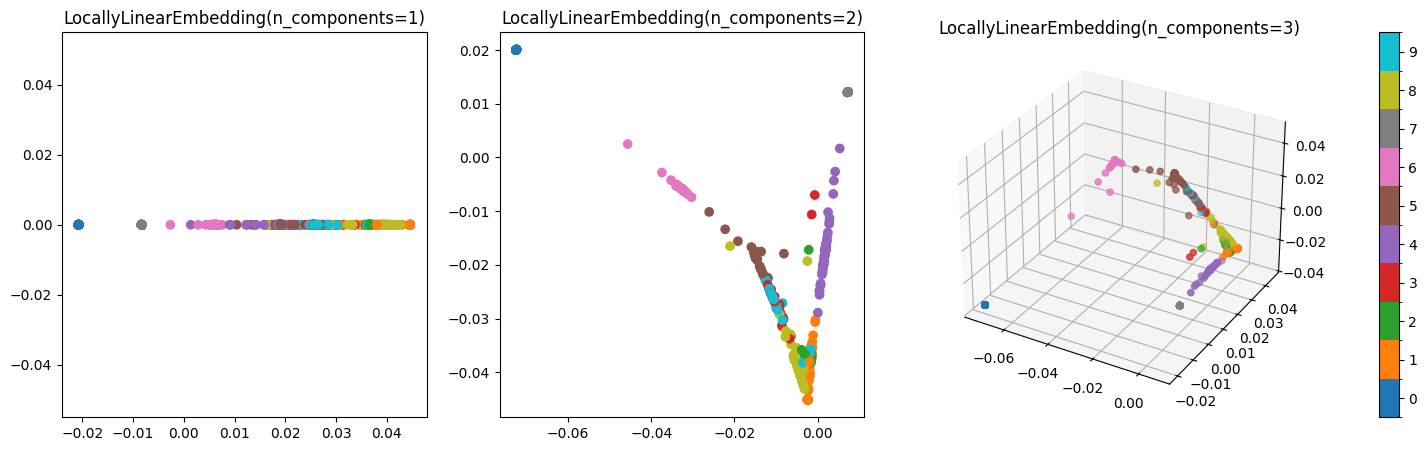

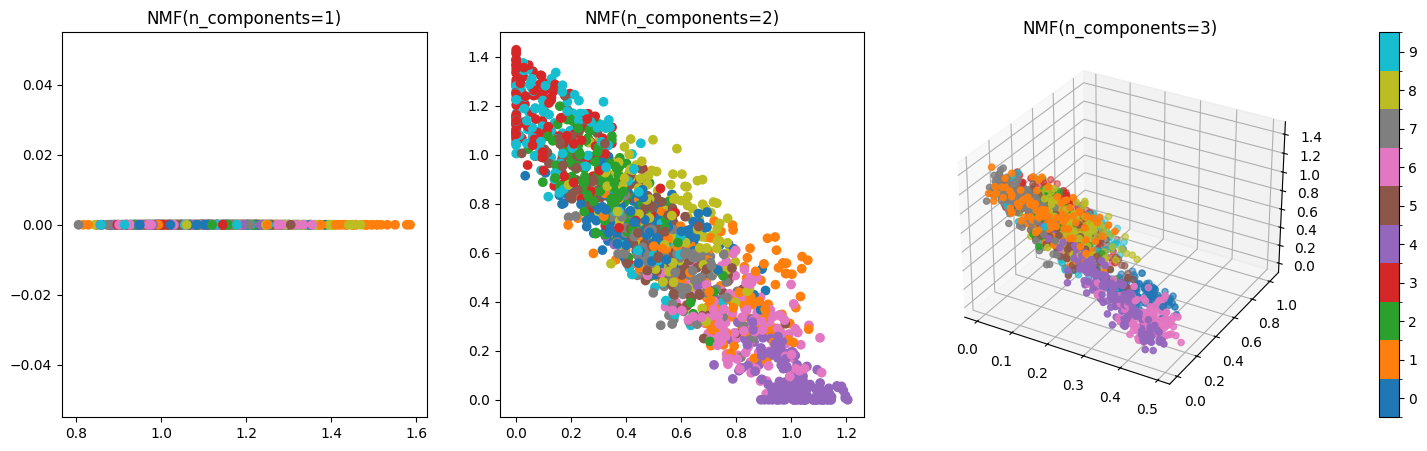

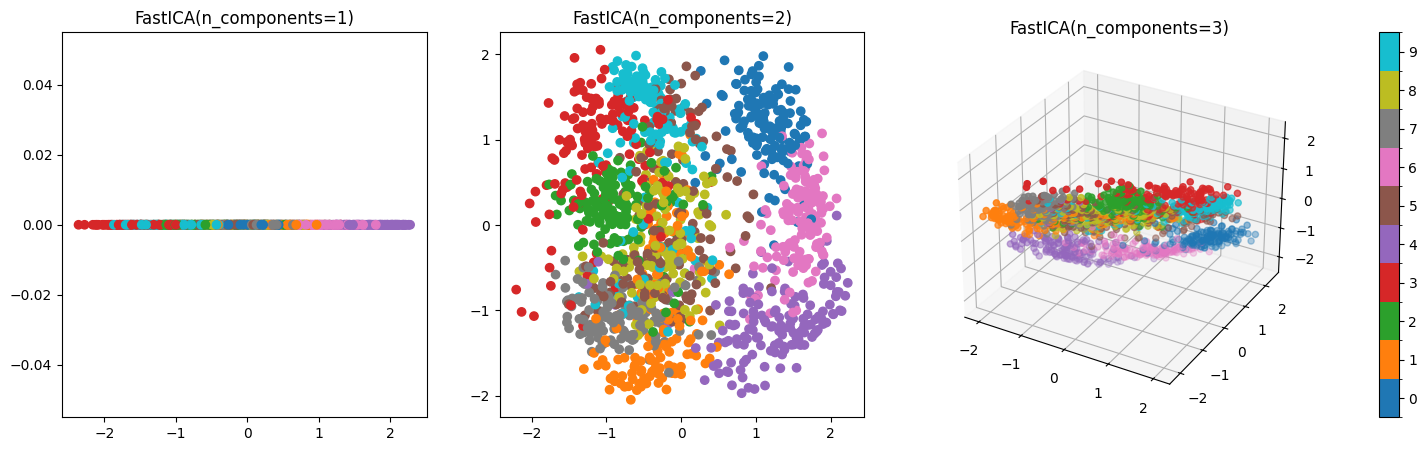

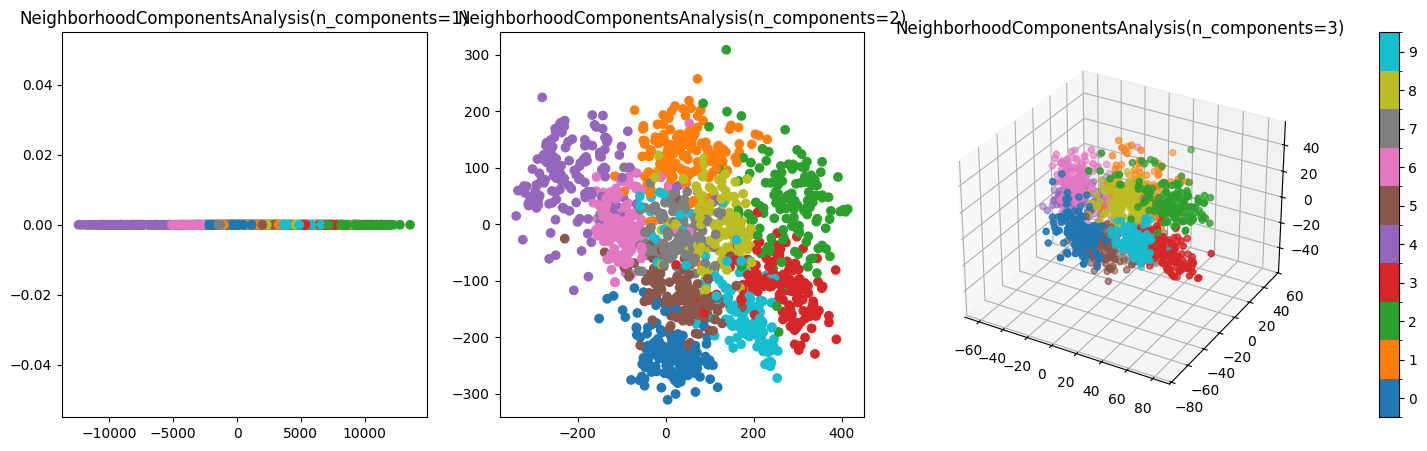

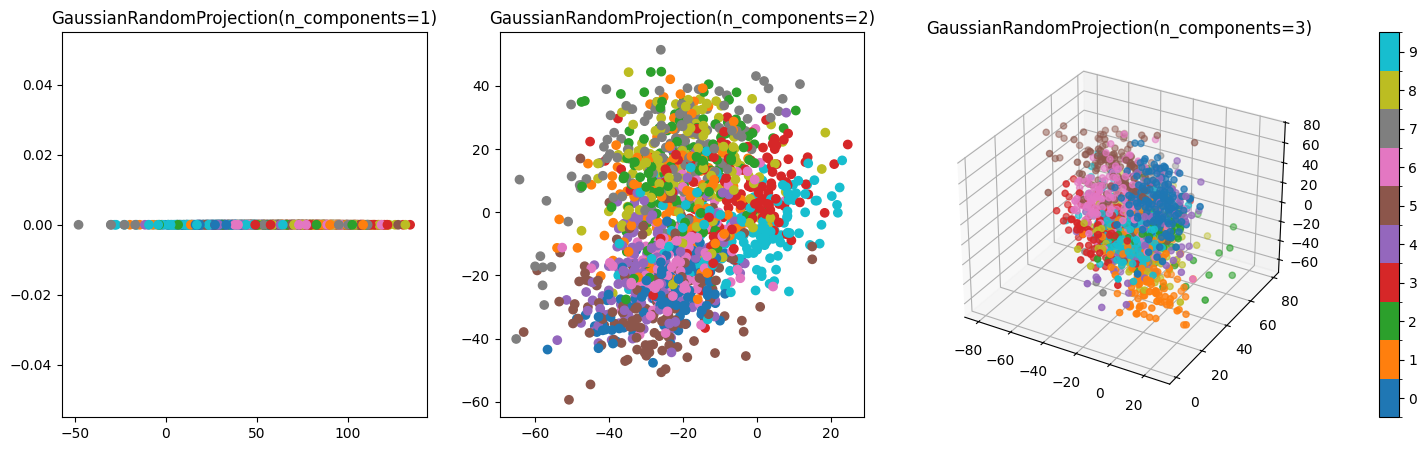

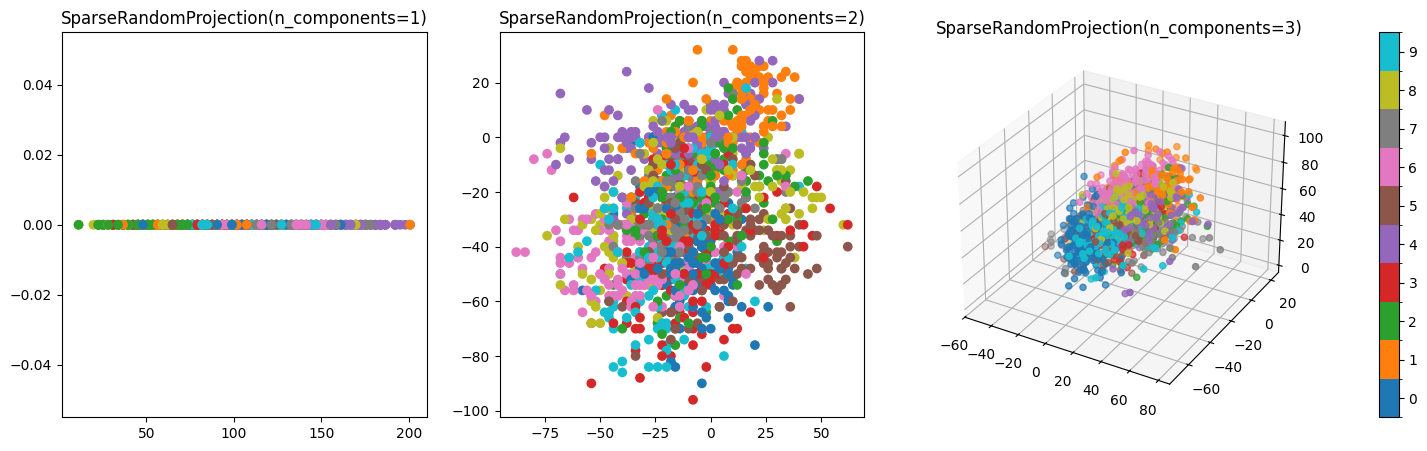

In [6]:
plot_feature_reduction(PCA, X_train, y_train)
plot_feature_reduction(LinearDiscriminantAnalysis, X_train, y_train)
plot_feature_reduction(TruncatedSVD, X_train, y_train)
plot_feature_reduction(Isomap, X_train, y_train)
plot_feature_reduction(LocallyLinearEmbedding, X_train, y_train)
plot_feature_reduction(NMF, X_train, y_train)
plot_feature_reduction(FastICA, X_train, y_train)
plot_feature_reduction(NeighborhoodComponentsAnalysis, X_train, y_train)
plot_feature_reduction(GaussianRandomProjection, X_train, y_train)
plot_feature_reduction(SparseRandomProjection, X_train, y_train)

### Hyperparameter Search

In [7]:
grid_search = GridSearchCV(
    estimator=Pipeline([
        ("feature_reduction", None),
        ("classifier", LogisticRegression(max_iter=10_000)),
    ]),
    param_grid={
        "feature_reduction": [
            PCA(),
            LinearDiscriminantAnalysis(),
            TruncatedSVD(),
            Isomap(max_iter=10_000),
            LocallyLinearEmbedding(max_iter=10_000),
            NMF(max_iter=10_000),
            FastICA(max_iter=10_000),
            NeighborhoodComponentsAnalysis(max_iter=10_000),
            GaussianRandomProjection(random_state=42),
            SparseRandomProjection(random_state=42),
        ],
        "feature_reduction__n_components": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    },
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="accuracy",
)
_ = grid_search.fit(X_train, y_train)

### Evaluation

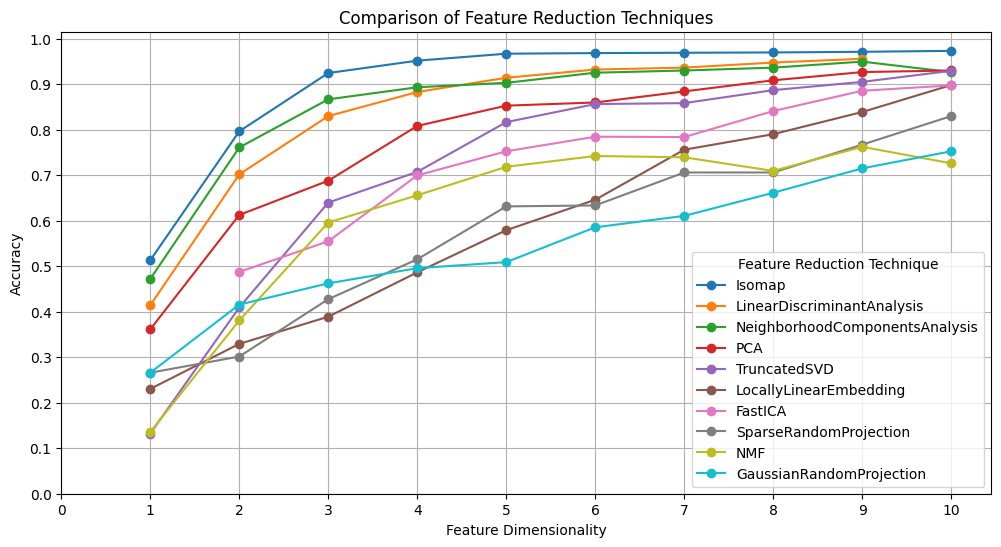

In [8]:
df = pd.DataFrame(grid_search.cv_results_)
df["param_feature_reduction"] = df["param_feature_reduction"].map(lambda x: x.__class__.__name__)
df = df.pivot(
    index="param_feature_reduction__n_components",
    columns="param_feature_reduction",
    values="mean_test_score",
)
df = df[df.max().sort_values(ascending=False).index]
ax = df.plot(
    kind="line",
    marker="o",
    grid=True,
    figsize=(12, 6),
    xlabel="Feature Dimensionality",
    xticks=np.arange(0, 11, 1),
    ylabel="Accuracy",
    yticks=np.arange(0, 1.1, 0.1),
    title="Comparison of Feature Reduction Techniques",
)
ax.legend(title="Feature Reduction Technique")
plt.show()

### Decision

`Isomap` delivers the best accuracy and starts converging at `n_components=5`.